# Propuesta para imputar datos con la librería H2O.ai

Este proyecto se desarrolla en el marco de una investigación de maestría en Ciencias de la Tierra, y tiene como objetivo explorar el uso de modelos de aprendizaje automático con la librería **H2O.ai** para la imputación y pronóstico de datos de caudal en series temporales, especialmente en contextos donde se presentan vacíos de información en estaciones hidrometeorologicas.

---

### 📌 Información del proyecto

- **Autora:** Luisa Fernanda Buriticá Ruíz  
- **Inicio de desarrollo:** 3 de julio de 2025  
- **Final del desarrollo:** 1 de agosto de 2025  
- **Contacto:** lfburitir1@eafit.edu.co  


In [1]:
# 1. LIBRERIAS
# 1.1 Librerías importadas
import numpy as np                     # Operaciones numéricas
import tqdm
import os
import pandas as pd
import datetime

# 1.2 Módulos importados
import matplotlib.pyplot as plt

# 1.3 Librerías propias
import config
from herramientas import (
observaciones,
correlacion_hexbin,
seleccion,
Analisis,
Analisis_Completo,
ObtenerDatos,
Analisis_datos_valoresperdidos_caudal,
Grafica_histograma_caudal
)

import h2o
import pandas as pd
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

### 📂 Rutas de entrada y salida

El script utiliza rutas definidas en un archivo de configuración para organizar la entrada y salida de archivos:

- `path_in`: ruta de entrada donde se almacenan los datos originales (por ejemplo, archivos `.csv` con series de caudal).
- `path_out`: ruta de salida donde se guardan los resultados generados, como gráficos, archivos procesados o reportes.

Estas rutas se extraen desde el objeto `config`:


In [2]:
path_in = config.path_in
path_out = config.path_out

###  Análisis completo de variables hidrometeorológicas

La función `Analisis_Completo(path_in, path_out)` ejecuta un análisis automatizado para un conjunto de variables hidrológicas, meteorológicas y de temperatura contenidas en las bases de datos de IDEAM.

Este análisis realiza lo siguiente para cada variable:
- **Lectura de datos** por estación.
- **Cálculo de estadísticas básicas**: fechas de inicio y fin, total de observaciones, frecuencia temporal, y porcentaje de datos perdidos.
- **Visualización** de la relación entre el tamaño de la serie de tiempo y el porcentaje de datos perdidos, mediante gráficos `hexbin` y líneas de regresión.
- **Exportación** de los resultados como archivos `.csv` y gráficos `.png`.

In [3]:
#Analisis_Completo(path_in, path_out)

### Selección y análisis de la estación de caudal `25027200` (Q_MEDIA_D)

En este bloque se realiza la exploración de los archivos disponibles en el conjunto de datos de hidrología diaria (`HidrologiaNacionalDiaria`). Se selecciona específicamente la estación con código `25027200`, correspondiente a la variable `Q_MEDIA_D` (caudal promedio diario), y se ejecutan los siguientes pasos:

1. **Carga de datos** usando la función `ObtenerDatos`, con resampleo diario por promedio.
2. **Análisis de calidad de la serie**, determinando el porcentaje de datos perdidos, el intervalo dominante y fechas faltantes.
3. **Visualización** de la serie temporal y la distribución de los valores mediante histogramas y curvas KDE.

Se puede visualizar la ubicación de la estación 
- [🔗 Antioquia Mira Su Cielo](https://antioquiamirasucielo.org)

  0%|          | 0/4 [00:00<?, ?it/s]

📊 Estadísticas generales de la serie
- Fecha inicial: 1969-01-01
- Fecha final  : 2023-12-19
- Total de datos: 20,076
📈 Test de normalidad (Shapiro-Wilk) - p-valor: 0.0000
📉 Análisis de datos perdidos
- Intervalo dominante         : 1440 minutos
- Porcentaje de datos perdidos: 0.00 %
- Porcentaje de fechas nulas  : 0.00 %

📆 Total de fechas esperadas: 20,076
✅ Total de fechas reales   : 20,076
❌ Total de fechas faltantes: 0


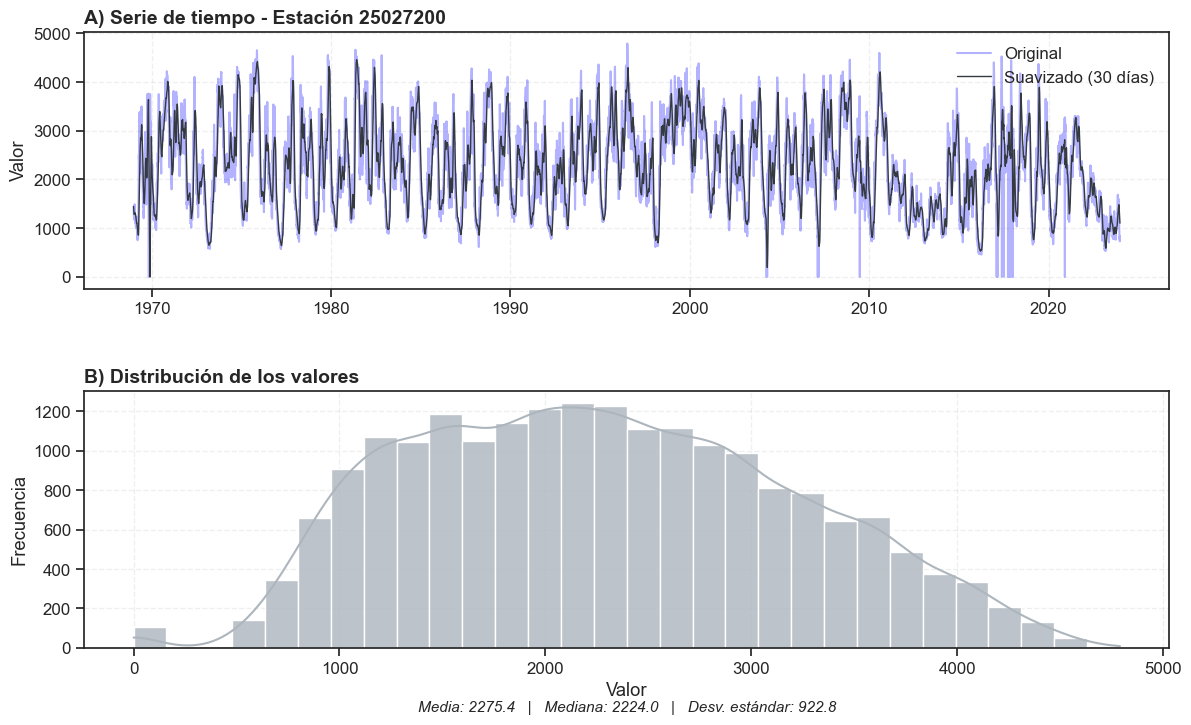

100%|██████████| 4/4 [00:01<00:00,  2.76it/s]


In [4]:
# Selección de la estación de caudal
import warnings
warnings.filterwarnings('ignore')
# Recorre todas las carpetas dentro de `path_in`
for i in tqdm.tqdm(os.listdir(path_in)):

    # Para cada archivo dentro de la subcarpeta (una por variable)
    for ii in os.listdir(f'{path_in}/{i}'):

        # Filtrar únicamente archivos de hidrología diaria
        if i == 'HidrologiaNacionalDiaria':

            # Extraer nombre de variable y código de estación desde el nombre del archivo
            variable = ii.split('@')[0]              # ejemplo: 'Q_MEDIA_D'
            codigo = ii.split('@')[1].split('.')[0]  # ejemplo: '25027200'

            # Seleccionar estación específica
            if codigo == '25027200' and variable == 'Q_MEDIA_D':

                # Cargar y procesar los datos desde el archivo
                df = ObtenerDatos(path=f'{path_in}/{i}/{ii}', tipo='promediada')

                # Analizar la calidad de los datos y mostrar resumen
                Analisis_datos_valoresperdidos_caudal(df)

                # Generar gráfico de la serie de tiempo e histograma
                Grafica_histograma_caudal(df, codigo, path_out)


## Inicio de la metodología con H2O.ai

A partir de esta sección se implementa la metodología de modelado utilizando la librería **H2O.ai**, una plataforma de código abierto para aprendizaje automático y análisis de datos a gran escala.

### Pasos iniciales:

- Se inicia el servidor local de H2O con `h2o.init()`.
- Se asegura el orden cronológico de la serie de tiempo y se reinicia el índice del DataFrame.
- Los datos son convertidos al formato `H2OFrame`, requerido para usar los estimadores de la librería.

### Referencias oficiales:

- [🔗 Documentación general de H2O.ai (versión estable)](https://docs.h2o.ai/h2o/latest-stable/h2o-docs/index.html)
- [🔗 H2O Python API Reference](https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/index.html)
- [🔗 H2O Deep Learning Estimator (Python)](https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/_modules/h2o/estimators/deeplearning.html)

> ⚠️ Nota: Esta metodología requiere tener instalado Java (JRE) en el sistema y haber configurado correctamente el entorno de ejecución para H2O.


In [5]:

# 🔄 Inicia el servidor local de H2O
# Este paso es obligatorio para poder usar las funcionalidades de modelado de H2O.ai
h2o.init()

# 📅 Asegura que los datos estén ordenados cronológicamente por la columna 'fecha'
# Esto es especialmente importante en series de tiempo antes de entrenar modelos
df = df.sort_values('fecha').reset_index(drop=True)

# 🔄 Convierte el DataFrame de pandas a un H2OFrame
# H2OFrame es el formato de datos nativo que utilizan todos los modelos de la librería H2O.ai
hf = h2o.H2OFrame(df)


Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; OpenJDK 64-Bit Server VM Temurin-21.0.8+9 (build 21.0.8+9-LTS, mixed mode, sharing)
  Starting server from C:\Users\Luisa F\anaconda3\envs\coastsat\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\LUISAF~1\AppData\Local\Temp\tmpeoyoxr3h
  JVM stdout: C:\Users\LUISAF~1\AppData\Local\Temp\tmpeoyoxr3h\h2o_Luisa_F_started_from_python.out
  JVM stderr: C:\Users\LUISAF~1\AppData\Local\Temp\tmpeoyoxr3h\h2o_Luisa_F_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,America/Bogota
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,4 months and 7 days
H2O_cluster_name:,H2O_from_python_Luisa_F_xdqkin
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,5.917 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


## Creación de variables de retardo para modelado supervisado

Para poder entrenar un modelo supervisado con H2O.ai o cualquier otra herramienta de aprendizaje automático, es necesario transformar la serie de tiempo en una estructura tipo matriz, donde se definan explícitamente las variables de entrada (`X`) y la variable objetivo (`y`).

En este caso, se generan **variables de retardo (lags)**, que representan los valores pasados del caudal. Estas variables permiten al modelo aprender patrones temporales y dependencias en la serie de tiempo.

Por ejemplo:
- Si se usan 5 lags (`n_lags=5`), el modelo aprenderá a predecir el valor actual del caudal en función de los **últimos 5 valores observados**.

Esta estrategia convierte el problema en una tarea de **regresión supervisada**, donde cada fila del nuevo DataFrame representa un ejemplo de entrenamiento con su correspondiente historial de datos.

La función `crear_lags()` implementa esta transformación.


In [6]:
def crear_lags(df, columna='valor', n_lags=5):
    """
    Crea variables de retardo (lags) para una serie de tiempo.

    Parámetros:
    - df: DataFrame original que contiene la serie de tiempo.
    - columna: nombre de la columna sobre la cual se aplicarán los retardos (por defecto 'valor').
    - n_lags: número de retardos que se desea generar.

    Retorna:
    - Un nuevo DataFrame con columnas adicionales para cada retardo, excluyendo las filas con NaNs iniciales.
    """
    df_lag = df.copy()
    for i in range(1, n_lags + 1):
        df_lag[f'{columna}_lag_{i}'] = df_lag[columna].shift(i)  # Crea la columna con el valor desplazado i pasos hacia atrás
    return df_lag.dropna().reset_index(drop=True)  # Elimina filas con NaN (causados por los lags) y reinicia el índice

# Generar las variables de entrada para el modelo basadas en 5 retardos
df_lags = crear_lags(df, columna='valor', n_lags=5)


## Preparación de los datos para entrenamiento y prueba

Una vez generadas las variables de retardo (lags), se procede a preparar los datos para el entrenamiento del modelo supervisado en H2O.ai.

### Definición de variables predictoras y objetivo
- **X (predictoras):** Se seleccionan todas las columnas que comienzan con `valor_lag_`, las cuales representan los valores pasados del caudal.
- **y (objetivo):** Se define como `valor`, que es el valor de caudal actual que se quiere predecir.

### División del dataset
Se realiza una partición del conjunto de datos en:
- **80 % para entrenamiento** (`train`)
- **20 % para validación/prueba** (`test`)


In [7]:
# Convertir el DataFrame con lags en un H2OFrame
# Este formato es requerido para entrenar modelos en H2O.ai
hf_lags = h2o.H2OFrame(df_lags)

# Definir las variables predictoras (X) y la variable objetivo (y)
# X incluye todas las columnas que comienzan con 'valor_lag_'
x = [col for col in hf_lags.columns if col.startswith('valor_lag_')]
y = 'valor'  # La variable que se quiere predecir

# Dividir el dataset en conjunto de entrenamiento y prueba
# 80% para entrenamiento, 20% para prueba (evaluación)
train, test = hf_lags.split_frame(ratios=[0.8], seed=1234)


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


## Entrenamiento del modelo de red neuronal profunda (Deep Learning)

En esta etapa se define y entrena un modelo de tipo `H2ODeepLearningEstimator` utilizando la librería **H2O.ai**. Este estimador se basa en redes neuronales profundas y permite capturar patrones no lineales complejos en la serie de tiempo.

### Configuración del modelo:
- **Activación:** `RectifierWithDropout`, una función que combina la activación ReLU con regularización por dropout para prevenir el sobreajuste.
- **Capas ocultas:** Dos capas con 64 neuronas cada una.
- **Épocas:** 50 iteraciones completas sobre el conjunto de entrenamiento.
- **Regularización:** L1 y L2 con coeficientes bajos (`1e-5`) para controlar la complejidad del modelo.
- **Criterio de detención temprana:** Basado en el RMSE (Root Mean Square Error), el entrenamiento se detiene si no mejora en 5 rondas consecutivas con un cambio menor al `0.0001`.

### Proceso de entrenamiento:
El modelo se entrena utilizando el conjunto `train` (80 % de los datos) y se valida continuamente con el conjunto `test` (20 %). Esta validación cruzada garantiza una evaluación objetiva del desempeño durante el ajuste del modelo.


In [8]:
# Definición del modelo de red neuronal profunda usando H2O.ai
modelo = H2ODeepLearningEstimator(
    activation='RectifierWithDropout',  # Función de activación con regularización por dropout
    hidden=[64, 64],                    # Arquitectura: dos capas ocultas con 64 neuronas cada una
    epochs=50,                          # Número total de iteraciones (épocas) sobre el conjunto de entrenamiento
    l1=1e-5,                            # Regularización L1 para evitar sobreajuste
    l2=1e-5,                            # Regularización L2 para mayor robustez
    stopping_metric="RMSE",            # Métrica de detención temprana (Root Mean Square Error)
    stopping_rounds=5,                 # Número de iteraciones sin mejora antes de detener el entrenamiento
    stopping_tolerance=1e-4,           # Umbral de tolerancia para determinar mejoras mínimas
    seed=42                            # Semilla para reproducibilidad del modelo
)

# Entrenamiento del modelo con los datos preparados
# x: lista de variables predictoras (lags), y: variable objetivo (valor actual)
# training_frame: conjunto de entrenamiento, validation_frame: conjunto de validación
modelo.train(x=x, y=y, training_frame=train, validation_frame=test)


deeplearning Model Build progress: |█████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ODeepLearningEstimator : Deep Learning
Model Key: DeepLearning_model_python_1754264223439_1


Status of Neuron Layers: predicting valor, regression, gaussian distribution, Quadratic loss, 4.609 weights/biases, 59,7 KB, 807.400 training samples, mini-batch size 1
    layer    units    type              dropout    l1     l2     mean_rate             rate_rms                momentum    mean_weight             weight_rms           mean_bias              bias_rms
--  -------  -------  ----------------  ---------  -----  -----  --------------------  ----------------------  ----------  ----------------------  -------------------  ---------------------  -----------------------
    1        5        Input             0.0
    2        64       RectifierDropout  50.0       1e-05  1e-05  0.006164473315220675  0.003832693211734295    0.0         -0.0008008349478586752  0.1982671618461609   0.4531638323842696     0.1217292845249176
    3        64       RectifierDropout  50.0       1e-05  1e-05  0.017123949161671703  0.013973668217658997    0.0         -0.05449114884841144    0.13319766521453857  0.9617488966108159     0.13170164823532104
    4        1        Linear                       1e-05  1e-05  0.001224192891640996  0.00047075015027076006  0.0         0.003587027225876227    0.17033571004867554  -0.044458844250950376  1.0971281125650402e-154

ModelMetricsRegression: deeplearning
** Reported on train data. **

MSE: 60960.792575778956
RMSE: 246.9023948360545
MAE: 187.84269119290903
RMSLE: 0.4774157129198093
Mean Residual Deviance: 60960.792575778956

ModelMetricsRegression: deeplearning
** Reported on validation data. **

MSE: 61191.10842319881
RMSE: 247.3683658497966
MAE: 187.3293112212484
RMSLE: 0.4513623828948005
Mean Residual Deviance: 61191.10842319881

Scoring History: 
    timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_deviance    training_mae    training_r2    validation_rmse    validation_deviance    validation_mae    validation_r2
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  -------------------  --------------  -------------  -----------------  ---------------------  ----------------  ---------------
    2025-08-03 18:37:09  0.000 sec                     0         0             0          nan              nan                  nan             nan            nan                nan                    nan               nan
    2025-08-03 18:37:10  1.486 sec   116676 obs/sec    5         1             80740      246.902          60960.8              187.843         0.928117       247.368            61191.1                187.329           0.926857
    2025-08-03 18:37:12  3.863 sec   267262 obs/sec    50        10            807400     423.711          179531               323.092         0.788302       421.51             177670                 322.301           0.787627
    2025-08-03 18:37:13  3.903 sec   266997 obs/sec    50        10            807400     246.902          60960.8              187.843         0.928117       247.368            61191.1                187.329           0.926857

Variable Importances: 
variable     relative_importance    scaled_importance    percentage
-----------  ---------------------  -------------------  ------------
valor_lag_1  1                      1                    0.346078
valor_lag_2  0.542126               0.542126             0.187618
valor_lag_4  0.475334               0.475334             0.164502
valor_lag_3  0.473337               0.473337             0.163811
valor_lag_5  0.398728               0.398728             0.137991

[tips]
Use `model.explain()` to inspect the model.
--
Use `h2o.display.toggle_user_tips()` to switch on/off this section.

## Evaluación del modelo y generación de predicciones

Una vez entrenado el modelo, se evalúa su desempeño utilizando el conjunto de prueba (`test`). Para ello, se aplican métricas de regresión como:

- **RMSE** (Root Mean Square Error)
- **MAE** (Mean Absolute Error)
- **R²** (Coeficiente de determinación)

Estas métricas permiten cuantificar la precisión del modelo al predecir valores no vistos durante el entrenamiento.

Posteriormente, se generan las predicciones sobre el conjunto de prueba y se convierten en un DataFrame de pandas, lo que facilita su análisis, visualización y comparación con los valores reales.


In [9]:
# Evaluación del desempeño del modelo sobre el conjunto de prueba
performance = modelo.model_performance(test_data=test)
print(performance)  # Muestra las métricas clave como RMSE, MAE, R², etc.

# Generación de predicciones sobre el conjunto de prueba
predicciones = modelo.predict(test)

# Conversión del objeto H2OFrame a un DataFrame de pandas para análisis o visualización
predicciones_df = predicciones.as_data_frame()



ModelMetricsRegression: deeplearning
** Reported on test data. **

MSE: 61191.10842319881
RMSE: 247.3683658497966
MAE: 187.3293112212484
RMSLE: 0.4513623828948005
Mean Residual Deviance: 61191.10842319881
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


## Comparación visual entre valores reales y predichos

En esta sección se presenta una visualización de los primeros 100 valores del conjunto de prueba para comparar el desempeño del modelo:

- **Línea negra**: representa los valores reales observados en la serie.
- **Línea roja (crimson)**: muestra los valores predichos por el modelo entrenado con H2O.ai.

Esta comparación permite identificar visualmente el ajuste del modelo y detectar posibles sesgos, desviaciones sistemáticas o errores de predicción.


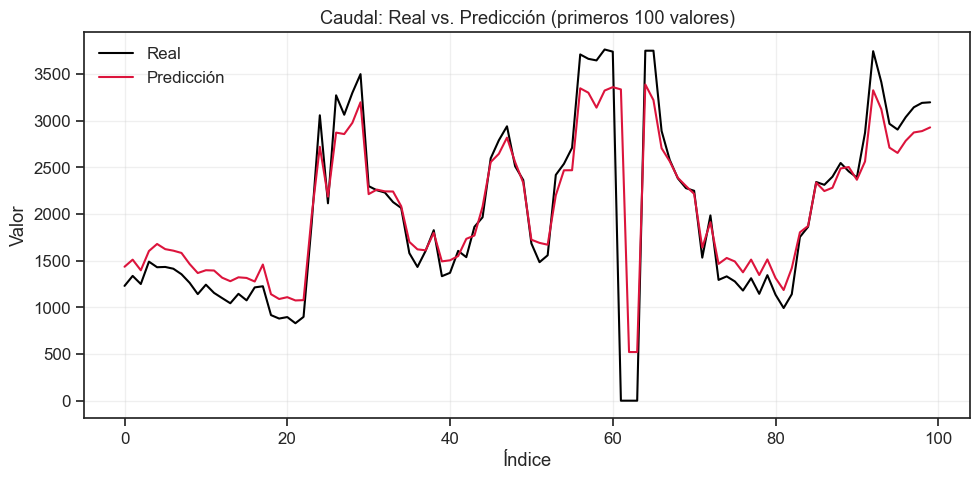

In [14]:

# Extraer los valores reales y predichos para comparación
valores_reales = test[y].as_data_frame().values.flatten()  # Convertir a array 1D
valores_predichos = predicciones_df.values.flatten()

# 📊 Graficar los primeros 100 valores reales vs. predichos
plt.figure(figsize=(10, 5))
plt.plot(valores_reales[:100], label='Real', color='black')          # Línea de datos reales
plt.plot(valores_predichos[:100], label='Predicción', color='crimson')  # Línea de predicciones
plt.title('Caudal: Real vs. Predicción (primeros 100 valores)')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
pathout = os.path.join(path_out, 'GRAFICOS', f'ComparacionVisual_Obs_Mod.png')
os.makedirs(os.path.dirname(pathout), exist_ok=True)
plt.savefig(pathout, dpi=300)
plt.show()


## Evaluación cuantitativa del modelo

Para evaluar el rendimiento del modelo en la predicción del caudal, se calcularon las siguientes métricas sobre el conjunto de prueba:

- **RMSE (Root Mean Squared Error):** mide el error promedio entre los valores reales y los predichos. Penaliza más los errores grandes.
- **MAE (Mean Absolute Error):** representa el promedio de las diferencias absolutas entre los valores reales y los predichos. Es más robusto ante outliers.
- **R² (Coeficiente de determinación):** indica qué tan bien el modelo explica la variabilidad de los datos. Un valor cercano a 1 indica un buen ajuste.

Estas métricas permiten una evaluación objetiva del modelo y sirven como referencia para futuras comparaciones o mejoras.


In [15]:
# Cálculo de métricas de evaluación para el modelo

# Raíz del error cuadrático medio (RMSE)
rmse = mean_squared_error(valores_reales, valores_predichos, squared=False)

# Error absoluto medio (MAE)
mae = mean_absolute_error(valores_reales, valores_predichos)

# Coeficiente de determinación (R²)
r2 = r2_score(valores_reales, valores_predichos)

# Imprimir los resultados con formato
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.3f}")


RMSE: 247.37
MAE: 187.33
R²: 0.927


## Comparación visual entre datos reales y predicciones

La siguiente figura presenta una comparación completa entre los valores reales del caudal y las predicciones generadas por el modelo entrenado con H2O.ai, utilizando el conjunto de prueba.

Esta visualización permite evaluar visualmente el ajuste del modelo a lo largo de toda la serie de prueba, identificando posibles desviaciones, tendencias capturadas correctamente, o errores sistemáticos.


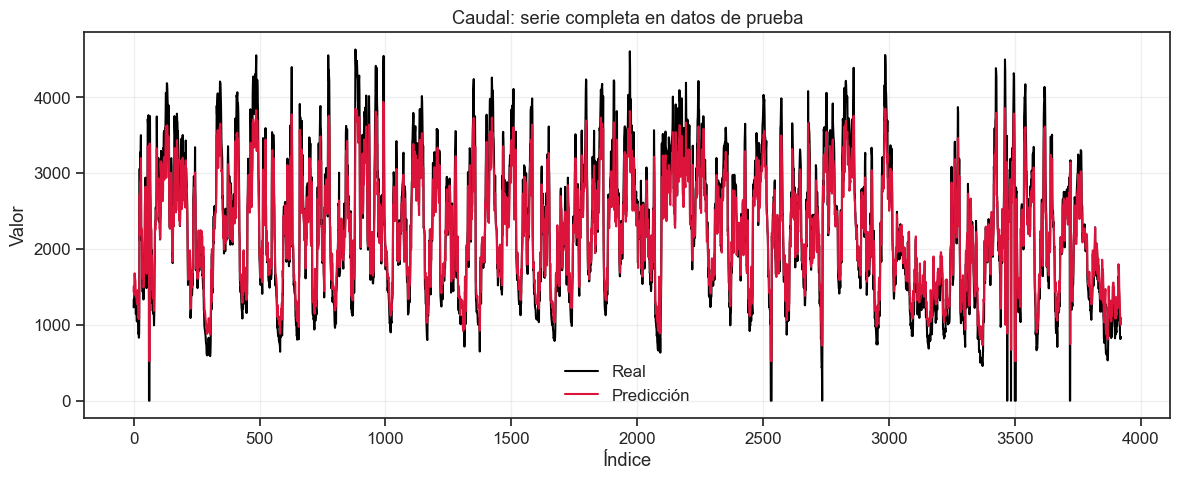

In [16]:
# 📈 Visualización de toda la serie de prueba: valores reales vs. predichos

plt.figure(figsize=(12, 5))  # Establece el tamaño de la figura
plt.plot(valores_reales, label='Real', color='black')  # Traza los valores reales de caudal
plt.plot(valores_predichos, label='Predicción', color='crimson')  # Traza las predicciones del modelo

# Título y etiquetas
plt.title('Caudal: serie completa en datos de prueba')
plt.xlabel('Índice')  # No se usa fecha aquí, solo la posición en la serie
plt.ylabel('Valor')

# Añadir leyenda y estilo
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
pathout = os.path.join(path_out, 'GRAFICOS', f'Completa_ComparacionVisual_Obs_Mod.png')
os.makedirs(os.path.dirname(pathout), exist_ok=True)
plt.savefig(pathout, dpi=300)
plt.show()


## Pronóstico autoregresivo de caudal con H2O.ai

En esta sección se implementa un modelo de pronóstico autoregresivo basado en la arquitectura `H2ODeepLearningEstimator`. El modelo utiliza las últimas observaciones reales como punto de partida, y genera predicciones para los siguientes 15 días.

Para visualizar el comportamiento reciente y la proyección futura, se presentan los últimos 60 días reales junto con los 15 días pronosticados. Esta representación ayuda a evaluar visualmente la continuidad del modelo y su habilidad para capturar las tendencias recientes de la serie.



Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
Parse progress: |█████████████████████████████████

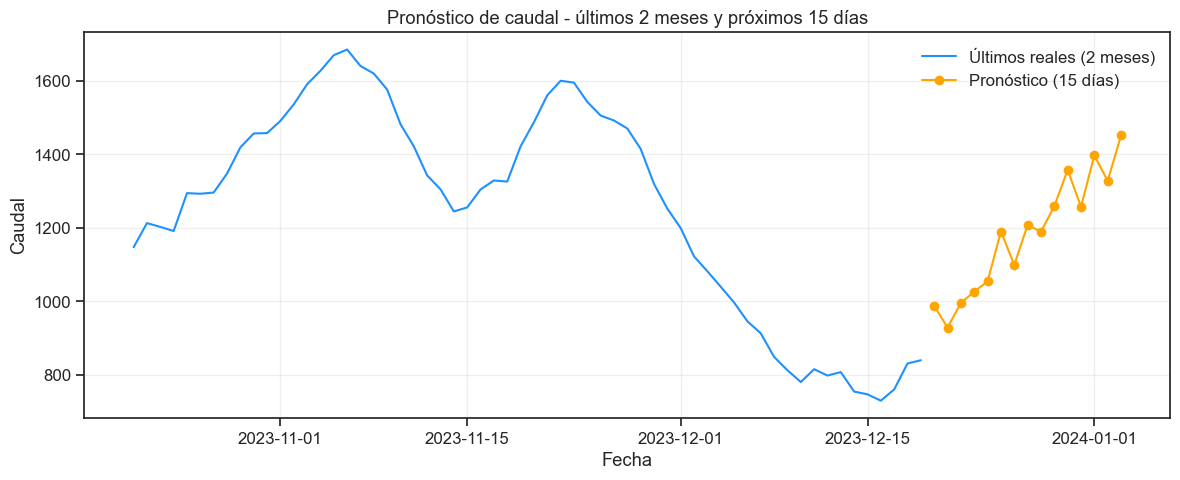

In [17]:
# Función para realizar un pronóstico autoregresivo
def pronostico_autoregresivo(modelo, df, n_dias=15, n_lags=5):
    # Se toman los últimos valores reales como base para comenzar el pronóstico
    ultimos_valores = df['valor'].values[-n_lags:].tolist()
    predicciones = []

    # Se generan predicciones día por día, usando un enfoque autoregresivo
    for _ in range(n_dias):
        # Crea un H2OFrame con las últimas observaciones como entrada para el modelo
        entrada = h2o.H2OFrame([ultimos_valores], column_names=[f'valor_lag_{i}' for i in range(1, n_lags + 1)])
        pred = modelo.predict(entrada).as_data_frame().iloc[0, 0]
        predicciones.append(pred)

        # Se actualizan los lags deslizando la ventana
        ultimos_valores = ultimos_valores[1:] + [pred]

    return predicciones

# Ejecutar el pronóstico de 15 días
pred_futuro = pronostico_autoregresivo(modelo, df_lags, n_dias=15)

# Generar las fechas correspondientes para el pronóstico
fechas_futuras = pd.date_range(start=df['fecha'].iloc[-1] + pd.Timedelta(days=1), periods=15, freq='D')

# Visualizar los últimos 60 días reales junto al pronóstico de 15 días
plt.figure(figsize=(12, 5))
plt.plot(df['fecha'][-60:], df['valor'][-60:], label='Últimos reales (2 meses)', color='dodgerblue')
plt.plot(fechas_futuras, pred_futuro, label='Pronóstico (15 días)', color='orange', marker='o')
plt.title('Pronóstico de caudal - últimos 2 meses y próximos 15 días')
plt.xlabel('Fecha')
plt.ylabel('Caudal')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
pathout = os.path.join(path_out, 'GRAFICOS', f'Pronostico.png')
os.makedirs(os.path.dirname(pathout), exist_ok=True)
plt.savefig(pathout, dpi=300)
plt.show()
